## Module Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Data Loading

- Calibration 변경시 수정 필요한 부분

In [2]:
# Loading the Data

avg_scaled_RGB = pd.read_csv('.\data\Table_dataset.csv')

avg_scaled_RGB.head()

,R,G,B,Thickness
0,11.576000,10.883200,8.136400,48.266667
1,10.826174,11.729849,9.594695,47.966667
2,13.336985,12.112036,8.233817,48.166667
3,9.354297,9.887613,6.912199,48.600000
4,4.799665,2.776091,1.086510,59.533333


In [3]:
from sklearn.model_selection import train_test_split

train_dt, test_dt = train_test_split(avg_scaled_RGB, test_size=0.3, random_state=42)
X_train = train_dt.drop(['Thickness'], axis=1)
y_train = train_dt['Thickness']

X_test = test_dt.drop(['Thickness'], axis=1)
y_test = test_dt['Thickness']

## 필요 함수 정의

In [4]:
# fitting 시간 측정용
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time() - ts
        print(f"Time consumed loading/training model :: {te:.2f} s")
        return result
    return timed

In [5]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 성능 평가 함수 및 Table 설정

def perf_eval_fc(y_pred, y_test):
    r2_score_val = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    return r2_score_val, MSE, RMSE, MAE, MAPE

perf_table = pd.DataFrame(columns=['R-square', 'RMSE', 'MSE', 'MAE', 'MAPE'])
perf_table

,R-square,RMSE,MSE,MAE,MAPE


In [6]:
# Disable the specific warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

# Hyperparameter Tuning
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

In [7]:
import pickle

MODEL_PATH = './model/'
PRED_PATH = './prediction/'

def save_model(model, model_name):
    pickle.dump(model, open(model_name, 'wb'))
    
def load_model(model_name):
    return pickle.load(open(model_name, 'rb'))

def save_prediction(y_pred, model_name):
    y_pred = pd.DataFrame(y_pred, columns = ['Predicted Thickness'])
    y_pred.to_csv(model_name, index=False)

In [8]:
@timeit
def fit_models(X_train, y_train, model_name, model, hyperparams=None, cv=None):
        try:
            opt = load_model(MODEL_PATH + model_name + '.pkl')
            print('Model found. Loading the model >> ' + model_name)
        except:
            print('Model not found. Training the model >> ' + model_name)
            if hyperparams is None:
                opt = model
                opt.fit(X_train, y_train)
            else:
                try:
                    opt = BayesSearchCV(model, hyperparams, cv=cv, n_iter=50, scoring='neg_mean_squared_error', n_jobs=-1)
                    opt.fit(X_train, y_train)
                except:
                    print('BayesSearchCV failed. Using the grid search >> ' + model_name)
                    opt = GridSearchCV(model, hyperparams, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
                    opt.fit(X_train, y_train)

            save_model(opt, MODEL_PATH + model_name + '.pkl')
        return opt

In [9]:
def update_table(perf_table, y_pred, y_test, model_name):
    r2_score_val, MSE, RMSE, MAE, MAPE = perf_eval_fc(y_pred, y_test)
    perf_table.loc[model_name] = [r2_score_val, RMSE, MSE, MAE, MAPE]
    return perf_table

- json 파일로 필요 모델별 hyperparameter Loading.
- hyperparameter 수정시 필요. calibration 비교시 필요 X

In [10]:
import json

with open('hyperparams.json') as f:
    hyperparams = json.load(f)
    
hyperparams

{'LinearRegression': None,
 'Ridge': {'alpha': [0.01, 10.0, 'log-uniform'],
  'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']},
 'Lasso': {'alpha': [0.01, 10.0, 'log-uniform'],
  'selection': ['cyclic', 'random']},
 'ElasticNet': {'alpha': [0.01, 10.0, 'log-uniform'],
  'l1_ratio': [0.0, 1.0],
  'selection': ['cyclic', 'random']},
 'SVR': {'C': [0.01, 10.0, 'log-uniform'],
  'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
  'gamma': [0.001, 1.0, 'log-uniform']},
 'Random Forest': {'n_estimators': [50, 500],
  'max_depth': [3, 30],
  'min_samples_split': [2, 20],
  'min_samples_leaf': [1, 20],
  'max_features': ['auto', 'sqrt', 'log2']},
 'Gradient Boosting': {'n_estimators': [50, 500],
  'learning_rate': [0.001, 0.2],
  'max_depth': [3, 30],
  'min_samples_split': [2, 20],
  'min_samples_leaf': [1, 20],
  'max_features': ['auto', 'sqrt', 'log2']},
 'Adaboost': {'n_estimators': [50, 500], 'learning_rate': [0.001, 1.0]},
 'XGBoost': {'n_estimators': [50, 500],
  'learning_rate': [0

## Training + Hyperparameter Optimization

- 사용 model 추가시 변경 필요. 이 외에는 변경 불필요.

In [11]:
# Dictionary to store the best models and their performance
best_models = {}

for model_name, model in zip(['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SVR', 'Random Forest', 'Gradient Boosting', 'Adaboost', 'XGBoost', 'LightGBM', 'KNeighborsRegressor', 'Decision Tree', 'MLPRegressor'],
                             [LinearRegression(), Ridge(), Lasso(), ElasticNet(), SVR(), RandomForestRegressor(), GradientBoostingRegressor(), AdaBoostRegressor(), XGBRegressor(), LGBMRegressor(), KNeighborsRegressor(), DecisionTreeRegressor(), MLPRegressor()]):
    
    best_models[model_name] = fit_models(X_train, y_train, model_name, model, hyperparams=hyperparams[model_name], cv=5)
    try:
        print("BEST PARAMS >> " + model_name + ": " + str(best_models[model_name].best_params_))
    except:
        print("No hyperparameters to tune >> " + model_name)
    
    print('*'*50)
    y_pred = best_models[model_name].predict(X_test)
    save_prediction(y_pred, PRED_PATH + model_name + '.csv')
    perf_table = update_table(perf_table, y_pred, y_test, model_name)

Model found. Loading the model >> LinearRegression
Time consumed loading/training model :: 0.00 s
No hyperparameters to tune >> LinearRegression
**************************************************
Model found. Loading the model >> Ridge
Time consumed loading/training model :: 0.08 s
BEST PARAMS >> Ridge: OrderedDict([('alpha', 10.0), ('solver', 'saga')])
**************************************************
Model found. Loading the model >> Lasso
Time consumed loading/training model :: 0.10 s
BEST PARAMS >> Lasso: OrderedDict([('alpha', 0.19070172971503388), ('selection', 'random')])
**************************************************
Model found. Loading the model >> ElasticNet
Time consumed loading/training model :: 0.07 s
BEST PARAMS >> ElasticNet: OrderedDict([('alpha', 6.065175450429075), ('l1_ratio', 0.0), ('selection', 'random')])
**************************************************


Model found. Loading the model >> SVR
Time consumed loading/training model :: 0.10 s
BEST PARAMS >> SVR: OrderedDict([('C', 10.0), ('gamma', 0.003270181096614778), ('kernel', 'rbf')])
**************************************************
Model found. Loading the model >> Random Forest
Time consumed loading/training model :: 0.10 s
BEST PARAMS >> Random Forest: OrderedDict([('max_depth', 30), ('max_features', 'auto'), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 50)])
**************************************************
Model found. Loading the model >> Gradient Boosting
Time consumed loading/training model :: 0.09 s
BEST PARAMS >> Gradient Boosting: OrderedDict([('learning_rate', 0.11834606347584736), ('max_depth', 30), ('max_features', 'auto'), ('min_samples_leaf', 5), ('min_samples_split', 17), ('n_estimators', 85)])
**************************************************
Model found. Loading the model >> Adaboost
Time consumed loading/training model :: 0.08 s
BEST PARAM

### 비교용 Tpot Testing

- 타 AutoML 알고리즘과 비교용

In [12]:
# 비교용 tpot
from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
tpot.fit(X_train, y_train)


# Perform predictions
y_pred = tpot.predict(X_test)
save_prediction(y_pred, PRED_PATH + 'TPOT.csv')
perf_table = update_table(perf_table, y_pred, y_test, 'TPOT')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -53.4683481410887

Generation 2 - Current best internal CV score: -53.4683481410887

Generation 3 - Current best internal CV score: -51.35804655120336

Generation 4 - Current best internal CV score: -48.66765317278573

Generation 5 - Current best internal CV score: -48.66765317278573

Best pipeline: AdaBoostRegressor(SelectFwe(XGBRegressor(input_matrix, learning_rate=0.01, max_depth=7, min_child_weight=20, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0), alpha=0.032), learning_rate=0.5, loss=square, n_estimators=100)


In [13]:
round(perf_table.sort_values(by='RMSE', ascending=True),5)

,R-square,RMSE,MSE,MAE,MAPE
Adaboost,0.94814,5.58615,31.20504,4.57761,4.90558
TPOT,0.94088,5.96433,35.57327,4.94573,5.40931
MLPRegressor,0.91261,7.25128,52.58109,5.17987,5.73063
LightGBM,0.91171,7.28861,53.12382,4.99894,5.19348
Gradient Boosting,0.88617,8.27600,68.49222,5.58565,5.66522
KNeighborsRegressor,0.88220,8.41910,70.88128,4.95341,4.82855
XGBoost,0.85768,9.25381,85.63294,5.99084,6.15135
Decision Tree,0.84177,9.75758,95.21028,6.72929,6.96929
Random Forest,0.83576,9.94107,98.82482,6.04127,5.89253
SVR,0.63740,14.77090,218.17934,7.57530,7.23263


In [14]:
Best_model = perf_table.sort_values(by='RMSE', ascending=True).index[0]
print("Best model >> " + Best_model)
print('Best parameters >> ' + str(best_models[Best_model].best_params_))
print('Best performance >> \n' + str(perf_table.loc[Best_model]))
# Load the best model
Best_model = load_model(MODEL_PATH + Best_model + '.pkl')
y_pred = Best_model.predict(X_test)


Best model >> Adaboost
Best parameters >> OrderedDict([('learning_rate', 0.6486410402962505), ('n_estimators', 51)])
Best performance >> 
R-square     0.948140
RMSE         5.586147
MSE         31.205038
MAE          4.577614
MAPE         4.905582
Name: Adaboost, dtype: float64


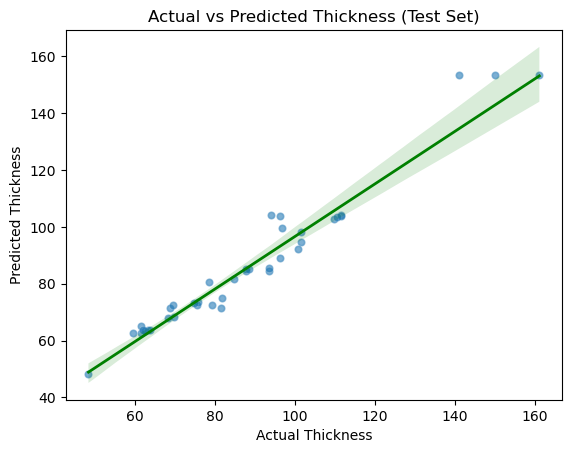

In [15]:
# 그래프 그리기
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test Set)')
plt.show()

In [16]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,72.546667
1,61.300000,62.700000
2,68.700000,71.332051
3,96.633333,99.508333
4,101.466667,94.672043
5,63.166667,63.735417
6,69.433333,72.546667
7,96.266667,89.031481
8,61.466667,65.212121
9,111.533333,104.175926
